# 1. Chargement des librairies et données

## 1.1. Import des librairies

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import mlflow

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [256]:
# ML Flow
mlflow.set_experiment("Insurance_Model_Comparison")

<Experiment: artifact_location=('/Users/umbertoemonds/Documents/Simplon/Machine Learning '
 'Courses/insurance/mlruns/1'), creation_time=1769006266345, experiment_id='1', last_update_time=1769006266345, lifecycle_stage='active', name='Insurance_Model_Comparison', tags={'mlflow.experimentKind': 'custom_model_development'}>

## 1.2. Import des données

In [257]:
dataset = pd.read_csv("./dataset/insurance.csv")
df = pd.DataFrame(dataset)

display(df.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1.3. Vérification des données

In [258]:
print(" Nombre de lignes dupliquées : ", df.duplicated().sum(), "\n")

display(df[df.duplicated(keep=False)])

df = df.drop_duplicates()
print("\n→ Doublon supprimé")

print("\nDonnées manquantes :")
display(df.isna().sum())
print("\n→ Pas de données manquantes")

 Nombre de lignes dupliquées :  1 



,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631



→ Doublon supprimé

Données manquantes :


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


→ Pas de données manquantes


# 2. Modélisation automatisée

## 2.1. Split test-train

In [259]:
# Division en données d'entraînement (80 %) et données de test (20 %)

X = df.drop("charges", axis=1)
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42
)

## 2.2. Création et sauvegarde de la pipeline

In [260]:
def add_features(X):
    X = X.copy()
    X["smoker"] = X["smoker"].map({"yes": 1, "no": 0})
    X["smoker_obese"] = X["smoker"] * (X["bmi"] >= 30).astype(int)
    X["age"] = X["age"] ** 2
    return X

categorical_features = ["region", "sex"]
numerical_features = ["age", "children", "smoker", "smoker_obese"]

preprocessor_withFeatures = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(drop='first'), categorical_features),
        ("numerical", StandardScaler(), numerical_features)
    ]
)

pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(add_features)),
    ('preprocessor', preprocessor_withFeatures),
    ('regressor', LinearRegression())
])


## Comparaison vers MLFlow

In [261]:
# Initialisation des trois modèles de comparaison
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
}

for name, mlflow_model in models.items():
    with mlflow.start_run(run_name=name):

        # On injecte le modèle dans le pipeline
        pipeline.set_params(regressor=mlflow_model)

        # Cross validation
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
        mae = np.abs(scores.mean())
        std = scores.std()

        mlflow.log_param("model_name", name)
        mlflow.log_metric("MAE_mean", mae)

        mlflow.sklearn.log_model(pipeline, name="pipeline_artifact")

        print(f"{name} terminé. MAE: {mae:.2f}")

Linear terminé. MAE: 2522.79
Ridge terminé. MAE: 2523.99
Lasso terminé. MAE: 2522.80


## 2.3. Cross validation

In [262]:
# Evaluation du modèle (MAE) avec validation croisée
cv_scores = cross_val_score(
    estimator = pipeline,
    X = X_train,
    y = y_train,
    cv = 5,
    scoring = "neg_mean_absolute_error"
)

print("Scores de validation croisée (5-fold) :")
print(f"  Scores : {[f'{abs(score):.2f}' for score in cv_scores]}")
print(f"  Moyenne : {abs(cv_scores.mean()):.2f} (+/- {cv_scores.std():.2f})")

Scores de validation croisée (5-fold) :
  Scores : ['2865.49', '2400.59', '2430.06', '2364.91', '2552.97']
  Moyenne : 2522.80 (+/- 182.65)


In [263]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

print("Scores de validation croisée (5-fold) :")
print(f"  Scores : {[f'{score:.2%}' for score in cv_scores]}")
print(f"  Moyenne : {cv_scores.mean():.2%} (+/- {cv_scores.std():.2%})")

Scores de validation croisée (5-fold) :
  Scores : ['80.62%', '87.68%', '84.77%', '85.85%', '86.06%']
  Moyenne : 85.00% (+/- 2.38%)


## 2.4. Comparaison de modèles avec GridSearchCV

In [264]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


models = [
    ('Linear Regression', LinearRegression()),
    ('Lasso', Lasso(max_iter=10000)),
    ('Ridge', Ridge()),
    ('ElasticNet', ElasticNet(max_iter=10000))
]

param_grids = [
    {'regressor__fit_intercept': [True, False]},
    {'regressor__alpha': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],},
    {'regressor__alpha': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 1000],},
    {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],}
]

"""
param_grids = [
    {'regressor__fit_intercept': [True, False]},
    {'regressor__alpha': [0.1, 1, 10]},
    {'regressor__alpha': [0.1, 1, 10]}
]"""

results = []

for (name, model), param_grid in zip(models, param_grids):

    print(f"Entraînement de {name}...")
    pipeline = Pipeline([
        ('feature_engineering', FunctionTransformer(add_features)),
        ('preprocessor', preprocessor_withFeatures),
        ('regressor', model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    # Prédictions sur le test
    y_pred = grid_search.predict(X_test)

    # Calcul des métriques
    test_r2 = r2_score(y_test, y_pred)
    test_mae = np.mean(np.abs(y_test - y_pred))
    test_rmse = (mean_squared_error(y_test, y_pred)) ** 0.5

    results.append({
        'Model': name,
        'Best Parameters': str(grid_search.best_params_),
        'Best CV R²': round(grid_search.best_score_, 4),
        'Test R²': round(test_r2, 4),
        'Test MAE': round(test_mae, 2),
        'Test RMSE': round(test_rmse, 2)
    })


results_df = pd.DataFrame(results)

# Affichage
print("\n" + "="*100)
print("résultats de comparaison des modèles")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

Entraînement de Linear Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Entraînement de Lasso...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Entraînement de Ridge...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Entraînement de ElasticNet...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

résultats de comparaison des modèles
            Model                    Best Parameters  Best CV R²  Test R²  Test MAE  Test RMSE
Linear Regression {'regressor__fit_intercept': True}        0.85   0.9041   2442.53    4198.47
            Lasso           {'regressor__alpha': 10}        0.85   0.9037   2440.93    4206.22
            Ridge           {'regressor__alpha': 10}        0.85   0.9034   2453.13    4212.77
       ElasticNet         {'regressor__alpha': 0.01}        0.85   0.9037   2447.61    4206.01


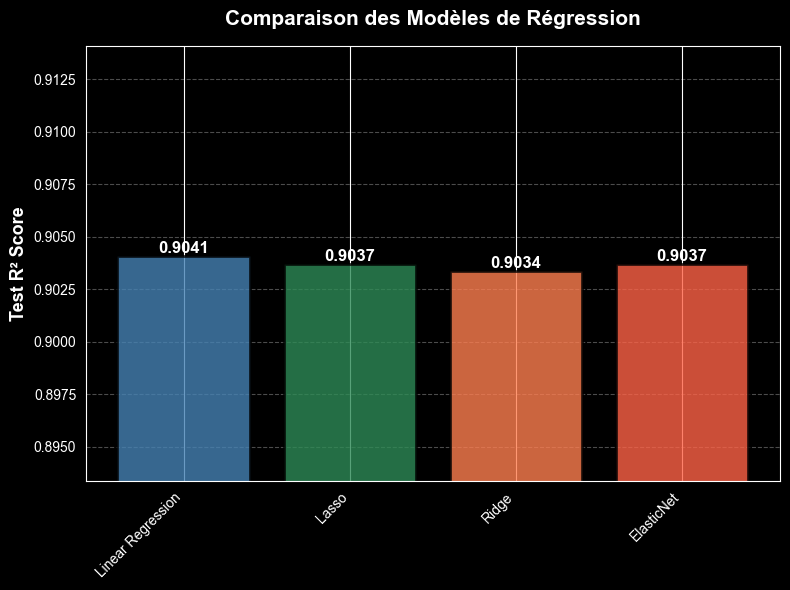

In [265]:
# Visualisation
plt.figure(figsize=(8, 6))
bars = plt.bar(results_df['Model'], results_df['Test R²'],
               color=['steelblue', 'seagreen', 'coral', 'tomato'],
               edgecolor='black', alpha=0.8, linewidth=2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Test R² Score', fontsize=13, fontweight='bold')
plt.title('Comparaison des Modèles de Régression', fontsize=15, fontweight='bold', pad=15)
plt.ylim(results_df['Test R²'].min() - 0.01, results_df['Test R²'].max() + 0.01)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 2.5. Prédictions sur les données de test


Mesures de performance (test) :


,R2,MAE,MSE
0,0.8309,3886.3931,5575.0734


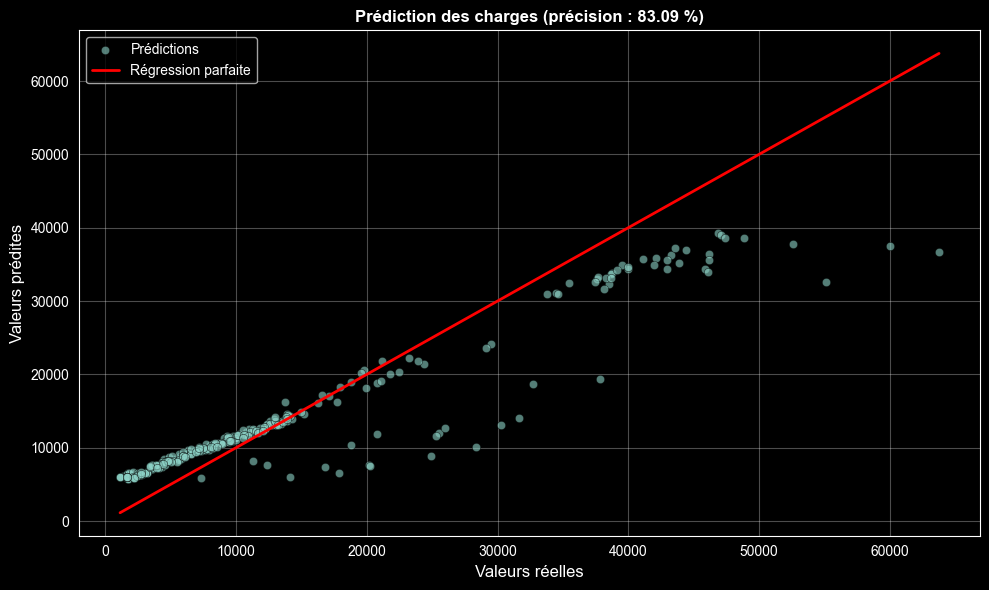

In [266]:
# Entraînement du modèle et prédictions sur les données de test
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


# Evaluation du modèle sur les données de test (scores R2, MAE, RMSE)
titles = ["R2", "MAE", "MSE"]

r2 = r2_score(y_test, y_pred)

scores = [
    r2,
    np.mean(np.abs(y_test - y_pred)),
    (mean_squared_error(y_test, y_pred)) ** 0.5
]

df_scores = pd.DataFrame([scores], columns=titles)

print(f"\nMesures de performance (test) :")

display(df_scores.round(4))



# Représentation graphique des prédictions
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors="k", linewidth=0.5, label="Prédictions")

plt.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            "r-", lw=2, label="Régression parfaite")

plt.xlabel("Valeurs réelles", fontsize=12)
plt.ylabel("Valeurs prédites", fontsize=12)
plt.title(f"Prédiction des charges (précision : {r2 * 100:.2f} %)", fontsize=12, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



# 3. Sauvegarde et Déploiement de Modèles

In [267]:
final_model = Pipeline([
    ('feature_engineering', FunctionTransformer(add_features)),
    ('preprocessor', preprocessor_withFeatures),
    ('regressor', LinearRegression())
])

final_model.fit(X, y)

# Prédictions
y_pred = final_model.predict(X)

# Evaluation du modèle sur les données de test (scores R2, MAE, RMSE)
titles = ["R2", "MAE", "MSE"]

r2 = r2_score(y, y_pred)

scores = [
    r2,
    np.mean(np.abs(y - y_pred)),
    (mean_squared_error(y, y_pred)) ** 0.5
]

df_scores = pd.DataFrame([scores], columns=titles)

print(f"\nMesures de performance (test) :")

display(df_scores.round(4))


Mesures de performance (test) :


,R2,MAE,MSE
0,0.865,2464.1179,4447.3197


In [268]:
# Sauvegarde avec joblib
model_filename = 'insurance_model.joblib'
joblib.dump(final_model, model_filename)

print(f"Modèle sauvegardé dans : {model_filename}")

# Vérification de la taille du fichier
import os
file_size = os.path.getsize(model_filename) / 1024  # En KB
print(f"Taille du fichier : {file_size:.2f} KB")

Modèle sauvegardé dans : insurance_model.joblib
Taille du fichier : 4.26 KB


# 4. Chargement du modèle

In [269]:
# Chargement du modèle
model_filename = 'insurance_model.joblib'
loaded_model = joblib.load(model_filename)
print("✓ Modèle chargé depuis le fichier")

✓ Modèle chargé depuis le fichier


In [270]:
## Vérification : faire une prédiction
test_data = pd.DataFrame({
    'age': [18],
    'children': [0],
    'smoker': ['no'],
    'bmi': [20],
    'sex': ['female'],
    'region': ['southeast']
})

# Faire la prédiction avec le modèle chargé
predicted_charges = loaded_model.predict(test_data)[0]

print(f"Prédiction des charges : {predicted_charges:.2f} €")

Prédiction des charges : 3099.41 €


Sauvegarde des métadonnées du modèle

In [271]:
import json
from datetime import datetime
import sklearn
from sklearn.metrics import r2_score

# Métadonnées du modèle
metadata = {
    'model_name': 'Prédicteur de charges d’assurance',
    'model_type': 'LinearRegression',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'sklearn_version': sklearn.__version__,
    'features': X.columns.tolist(),
    'preprocessing': [
        'Feature engineering (smoker, smoker_obese)',
        'OrdinalEncoder (binary features)',
        'OneHotEncoder (categorical features)',
        'RobustScaler (numerical features)'
    ],
    'description': 'Pipeline complet avec feature engineering et régression linéaire'
}

#Sauvegarde des métadonnées
metadata_filename = 'regression_model_metadata.json'
with open(metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=4, ensure_ascii=False)

print(f"Métadonnées sauvegardées : {metadata_filename}")

#Affichage
print("\n Métadonnées du modèle :")
print(json.dumps(metadata, indent=2, ensure_ascii=False))


Métadonnées sauvegardées : regression_model_metadata.json

 Métadonnées du modèle :
{
  "model_name": "Prédicteur de charges d’assurance",
  "model_type": "LinearRegression",
  "training_date": "2026-01-21 16:14:06",
  "sklearn_version": "1.7.2",
  "features": [
    "age",
    "sex",
    "bmi",
    "children",
    "smoker",
    "region"
  ],
  "preprocessing": [
    "Feature engineering (smoker, smoker_obese)",
    "OrdinalEncoder (binary features)",
    "OneHotEncoder (categorical features)",
    "RobustScaler (numerical features)"
  ],
  "description": "Pipeline complet avec feature engineering et régression linéaire"
}
